# A complex yet simple efficient training pipeline for CIFAR-10

This pipeline serves an educational purpose, hence that's why it's complex yet simple.

For a more complex and more efficient training pipeline for CIFAR-10, do check [CIFAR-10 speedruns: 94% in 2.6 seconds and 96% in 27 seconds](https://github.com/KellerJordan/cifar10-airbench).

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import v2
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
#import timm
from tqdm import tqdm

from multiprocessing import freeze_support
import time
from timed_decorator.simple_timed import timed

from pathlib import Path
import sys
from livelossplot import PlotLossesKeras

In [2]:

LCL_PATH  = str(Path().cwd())
ROOT_PATH = str(Path(LCL_PATH).parent)
DEEPL_PATH = str(Path(ROOT_PATH)/"deep_learning")
print("""
root path:\t{}
local path:\t{}
deep learning path:\t{}""".format(ROOT_PATH, LCL_PATH, DEEPL_PATH))


root path:	/home/gheorghe/Desktop/Proiecte/master/CARN
local path:	/home/gheorghe/Desktop/Proiecte/master/CARN/laborator_2
deep learning path:	/home/gheorghe/Desktop/Proiecte/master/CARN/deep_learning


In [3]:

# adding local_folder to the system path
sys.path.append(ROOT_PATH)
sys.path.append(LCL_PATH)
sys.path.append(DEEPL_PATH)

from sys_function import * # este in root

In [79]:

sys_remove_modules("dataset.dataset_rand_append")
sys_remove_modules("trainer.trainer")
sys_remove_modules("trainer.supervised_callback_metrics_trainer")
sys_remove_modules("trainer.supervised_callback_metrics_trainer_two_opt")
sys_remove_modules("my_transformers.one_hot")
sys_remove_modules("my_transformers.label_smoothing")
sys_remove_modules("models.supervised.resnet")
sys_remove_modules("models.supervised.resnext_se_sd")
sys_remove_modules("models.unsupervised.resnet_unsupervised")
sys_remove_modules("models.utils")
sys_remove_modules("conf_manager.train_conf")
sys_remove_modules("checks.tensor_check")
sys_remove_modules("metrics.accuracy")
sys_remove_modules("callback")

from dataset.dataset_rand_append import *
from trainer.trainer import *
from trainer.supervised_callback_metrics_trainer import *
from trainer.supervised_callback_metrics_trainer_two_opt import *
from my_transformers.one_hot import *
from my_transformers.label_smoothing import *
from models.supervised.resnet import *
from models.supervised.resnext_se_sd import *
from models.unsupervised.resnet_unsupervised import *
from models.utils import *
from conf_manager.train_conf import *
from checks.tensor_check import *
from metrics.accuracy import *
from callback import *

First we define some configuration variables

In [5]:
disable_compile = True
compile_is_slower = False
BATCH_SIZE = 24
IMAGE_SIZE = 32*2
NUM_CLASSES = 10

## Data aquisition

### Manipulation/preprocesing

#### Check function

In [6]:

def check_transforms(transform, inputs, shape, max_val, min_val, dtype):
    # check 1000 tests
    for _ in range(1000):
        x = transform(inputs)
        tensor_check(x, shape, max_val, min_val, dtype)
    else:
        print("OK")

In [7]:

def check_all_transforms(transform, inputs, outputs, in_shape, out_shape, max_val, min_val, dtype):
    for _ in range(1000):
        x, y = transform(inputs, outputs)
        tensor_check(x, in_shape, max_val, min_val, dtype)
        tensor_check(y, out_shape, 1.5, -1.3, dtype)
    else:
        print("OK")

#### Init transform

In [8]:

def get_init_transform(train, image_size):
    transform = [ # image->tensor->resize->make square-> 
            # if use 'ToImage' tensor should be numpy array!!!
            v2.ToImage(), # data are transorm to torch tensor in Dataset manager, tensor should be numpy array!!!
            v2.Resize(
                size=int(image_size),),
            v2.CenterCrop(image_size),
        ]
    if (train == False):
        transform.extend([
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(
                    mean=(0.5, 0.5, 0.5), 
                    std=(0.5, 0.5, 0.5), 
                    #mean=(0.491, 0.482, 0.446), 
                    #std=(0.247, 0.243, 0.261), 
                    inplace=True),
            ])
                # We use the inplace flag because we can safely change the tensors inplace when normalize is used.
                # For is_train=False, we can safely change the tensors inplace because we do it only once, when caching.
                # For is_train=True, we can safely change the tensors inplace because we clone the cached tensors first.
    return v2.Compose(transform)

In [ ]:

transform = get_init_transform(False, IMAGE_SIZE)
inputs = np.ones((32, 32, 3), dtype=np.uint8) * 255
shape = (3, IMAGE_SIZE, IMAGE_SIZE)
check_transforms(transform, inputs, shape, 1, -1, torch.float32)

In [ ]:

transform = get_init_transform(True, IMAGE_SIZE)
inputs = np.ones((32, 32, 3), dtype=np.uint8) * 255
shape = (3, IMAGE_SIZE, IMAGE_SIZE)
check_transforms(transform, inputs, shape, 255, 0, torch.uint8)

#### Transform

In [9]:

def get_transforms(image_size: int):
    # These transformations are cached.
    # We could have used RandomCrop with padding. But we are smart, and we know we cache the initial_transforms so
    # we don't compute them during runtime. Therefore, we do the padding beforehand, and apply cropping only at
    # runtime
    random_choice = v2.RandomChoice([
        v2.RandomPerspective(
                    distortion_scale=0.15, # controls how much each corner can move. 
                    p=1.0),                # probability of applying the effect
        v2.RandomRotation(degrees=30),     # rotates an image with random angle
        v2.RandomAffine(
                    degrees=30,             # rotation ±30
                    translate=(0.15, 0.15), # horizontal/vertical translation as fraction of image
                    scale=(0.75, 1.05),     # scale factor
                    shear=10),              # shear angle ±10°
        v2.RandomCrop(
                    size=image_size,   # height & width of crop
                    padding=4),        # pixels to pad around the image
        v2.RandomResizedCrop(
                    size=image_size,
                    scale=(0.75, 1.),  # range of area proportion to crop from the original image
                    ratio=(0.8,  1.)), # range of aspect ratio (width/height)
        v2.RandomAdjustSharpness(
                    sharpness_factor=1.5, # controls the degree of sharpness; ( >1 sharpened; <1 slightly blurred)
                    p=1.),                      # probability of applying the transform
        v2.RandomAutocontrast(p=1.), # probability of applying the transform
        v2.RandomEqualize( # histogram of pixel values
                    p=1.), # probability of applying the transform
        v2.ColorJitter(  # randomly changes the brightness, contrast, saturation, and hue
                    brightness=0.5, # factor to change brightness
                    contrast=0.3,   # factor to change contrast
                    saturation=0.3, # factor to change saturation
                    hue=0.3,),      # factor to change hue
        v2.GaussianBlur(  # applies a Gaussian blur
                    kernel_size=(7, 7), # size of the Gaussian kernel
                    # standard deviation of the Gaussian kernel; a float or tuple (min, max) for random sampling
                    sigma=(0.1, 5.)),   # how to handle image borders
        v2.RandomErasing(
                    scale=(0.01, 0.15), # range of area ratio to erase (relative to image area)
                    value=10,           # fill value: single number, tuple, or 'random'
                    inplace=False,      # whether to erase in place or return a new image
                    p=1.),              # probability of applying the transform
        v2.Grayscale(num_output_channels=3), # number of channels in output image: 1 or 3
        v2.RandomHorizontalFlip(),
        v2.Identity(),  # returns the input image unchanged
    ])
    transforms = v2.Compose([random_choice,
        v2.ToDtype(torch.float32, scale=True), # converts uint8 [0,255] -> float32 [0,1]
        v2.Normalize(
                mean=(0.5, 0.5, 0.5), 
                std=(0.5, 0.5, 0.5), 
                #mean=(0.491, 0.482, 0.446), 
                #std=(0.247, 0.243, 0.261), 
                inplace=True),
        ])
    # We use the inplace flag because we can safely change the tensors inplace when normalize is used.
    # For is_train=False, we can safely change the tensors inplace because we do it only once, when caching.
    # For is_train=True, we can safely change the tensors inplace because we clone the cached tensors first.

    # Q: How to make this faster?
    # A: Use batched runtime transformations. y
    return transforms

In [ ]:

transform = get_transforms(IMAGE_SIZE)
inputs = torch.ones((3, IMAGE_SIZE, IMAGE_SIZE), dtype=torch.uint8) * 255
shape = (3, IMAGE_SIZE, IMAGE_SIZE)
check_transforms(transform, inputs, shape, 3, -3, torch.float32)

#### All transform

In [10]:

def get_all_transforms(num_classes: int = 10):
    transforms = v2.RandomChoice([
                v2.CutMix(num_classes=num_classes),  # See the CutMix paper
                v2.MixUp(num_classes=num_classes),   # See the MixUp paper
                LabelSmoothing(num_classes=num_classes, smooth_size=0.13),  # 
            ])
    return transforms

In [ ]:

transform = get_all_transforms(num_classes=NUM_CLASSES)
inputs  = torch.ones((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32)
outputs = torch.zeros((BATCH_SIZE,), dtype=torch.int64)
print(transform)
in_shape  = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
out_shape = (BATCH_SIZE, NUM_CLASSES)
check_all_transforms(transform, inputs, outputs, in_shape, out_shape, 3, -3, torch.float32)

In [ ]:

tmp_l = LabelSmoothing(num_classes=10, smooth_size=0.13)
y = torch.zeros((BATCH_SIZE,), dtype=torch.int64)
for _ in range(1000):
    tmp0, tmp1 = tmp_l(None, y)
    if (torch.less(tmp1, 0).sum() > 0):
        print(torch.less(tmp1, 0).sum())

### Aquisition

In [11]:

cifar10_train = CIFAR10(root="./data", train=True, transform=None, download=True)
print(str(cifar10_train))
cifar10_test = CIFAR10(root="./data", train=False, transform=None, download=True)
print(str(cifar10_test))

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [12]:

d_train = dict(inputs=np.array(cifar10_train.data, dtype=np.uint8), 
               targets=np.array(cifar10_train.targets, dtype=np.uint16), 
               num_classes=NUM_CLASSES)
d_test  = dict(inputs=np.array(cifar10_test.data,  dtype=np.uint8), 
               targets=np.array(cifar10_test.targets,  dtype=np.uint16), 
               num_classes=NUM_CLASSES)

In [ ]:
d_train["inputs"][0].shape

### Efficient in-memory dataset wrapper for caching

Beware that this dataset keeps all data in memory. If it is too large, we might opt to cache the data on the disk and read it in `__getitem__()`.

In [82]:

VIRTUAL_CLASS     = 90
SAMPLES_PER_CLASS = 100
percent_from = VIRTUAL_CLASS * SAMPLES_PER_CLASS / d_train["inputs"].shape[0]
train_ds = DatasetRandAppend(d_train, transform=get_init_transform(True, IMAGE_SIZE), 
                             train=True,  virtual_classes=VIRTUAL_CLASS, percent_from=percent_from)
test_ds  = DatasetRandAppend(d_test,  transform=get_init_transform(False, IMAGE_SIZE), 
                             train=False)
eval_ds  = DatasetRandAppend(d_train, transform=get_init_transform(False, IMAGE_SIZE), 
                             train=False)
print("size: train_ds {}, test_ds {}".format(len(train_ds), len(test_ds)))

size: train_ds 59000, test_ds 10000


In [83]:
9000/50000

0.18

In [84]:

in_shape  = (3, IMAGE_SIZE, IMAGE_SIZE)
#in_shape  = (32, 32, 3)
out_shape = ()
for idx in range(1000):
    inputs, outputs = train_ds[idx]
    #print(type(outputs))
    tensor_check(inputs,  in_shape,  255, 0, torch.uint8, arr_type=torchvision.tv_tensors._image.Image)
    tensor_check(outputs, out_shape,  30, 0, np.int64, arr_type=np.int64)
else:
    print("OK")

OK


In [ ]:

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)
test_dl  = DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)

In [ ]:

transform     = get_transforms(IMAGE_SIZE)
all_transform = get_all_transforms(num_classes=train_ds.num_classes)
print(transform)
in_shape  = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
out_shape = (BATCH_SIZE, train_ds.num_classes)
for idx, (inputs, outputs) in zip(range(1000), train_dl):
    x    = transform(inputs)
    tensor_check(x, in_shape, 3, -3, torch.float32)
    x, y = all_transform(x, outputs)
    tensor_check(x, in_shape, 3, -3, torch.float32)
    tensor_check(y, out_shape, 1, 0, torch.float32)
else:
    print("OK")

In [ ]:

in_shape  = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
out_shape = (BATCH_SIZE, train_ds.num_classes)
for idx, (inputs, outputs) in zip(range(1000), test_dl):
    tensor_check(inputs, in_shape, 3, -3, torch.float32)
else:
    print("OK")

In [ ]:

@timed(use_seconds=True, show_args=True, return_time=True)
def load_data(dataset, num_workers: int):
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=False)
    for _ in dataloader:
        pass  # Simulate training

In [ ]:

times = []
freeze_support()
for num_workers in range(33):
    _, t0 = load_data(test_ds, num_workers)
    times.append(t0)
print("argmin {}".format(np.argmin(times)))

In [ ]:

times = []
freeze_support()
for num_workers in range(33):
    _, t0 = load_data(train_ds, num_workers)
    times.append(t0)
print("argmin {}".format(np.argmin(times)))

In [85]:

# select the best number workers
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=13, drop_last=False)
test_dl  = DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=False, num_workers=15, drop_last=False)
eval_dl  = DataLoader(eval_ds,  batch_size=BATCH_SIZE, shuffle=True,  num_workers=13, drop_last=False)

In [86]:

transform     = get_transforms(IMAGE_SIZE)
all_transform = get_all_transforms(num_classes=train_ds.num_classes)
print(all_transform)
in_shape  = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
out_shape = (BATCH_SIZE, train_ds.num_classes)
print("in_shape {}, out_shape {}".format(in_shape, out_shape))
for idx, (inputs, outputs) in zip(range(1000), train_dl):
    tensor_check(inputs, in_shape, 255, 0, torch.uint8, arr_type=torch.Tensor)
    x    = transform(inputs)
    tensor_check(x, in_shape, 1, -1, torch.float32)
    x, y = all_transform(x, outputs)
    tensor_check(x, in_shape, 1, -1, torch.float32)
    tensor_check(y, out_shape, 1., 0., torch.float32)
else:
    print("OK")

RandomChoice(transforms=[CutMix(alpha=1.0, num_classes=100), MixUp(alpha=1.0, num_classes=100), LabelSmoothing(num_classes=100, smooth_size=0.13, on_value=0.87)], p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
in_shape (24, 3, 64, 64), out_shape (24, 100)
OK


In [ ]:

in_shape  = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
out_shape = (BATCH_SIZE, train_ds.num_classes)
for idx, (inputs, outputs) in zip(range(1000), test_dl):
    tensor_check(inputs, in_shape, 3, -3, torch.float32)
else:
    print("OK")

## Autoencoder

In [19]:

"""
Input=(img_channels, out_channels, kernel_size, stride)
body={body_name={in_channels, expansion, stride, intermediate_channels, num_residual_blocks}}
Output=(in_features, out_features)
"""
resnet_conf = dict(
    Input=dict(
        img_channels=3, 
        out_channels=9, 
        kernel_size=3, 
        stride=1),
    encode=dict(
        enc_conv_1x=dict(in_channels=9, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=32, 
                     num_residual_blocks=5),
        enc_conv_2x=dict(in_channels=128, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=64, 
                     num_residual_blocks=4),
        enc_conv_3x=dict(in_channels=256, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=256, 
                     num_residual_blocks=3),
    ),
    decode=dict(
        dec_conv_1x=dict(in_channels=1024, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=256, 
                     num_residual_blocks=2),
        dec_conv_2x=dict(in_channels=1024, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=256, 
                     num_residual_blocks=2),
        dec_conv_3x=dict(in_channels=1024, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=256, 
                     num_residual_blocks=2),
    ),
    Output=(1024, 3)
)

In [20]:

unsupervised_model = ResNetUnsupervised("resnet_32x32_cifar", **resnet_conf)

In [21]:

filename = "{}/logs/{}".format(LCL_PATH, "unsupervised_deep_5x_conf_logs.pth")
unsupervized_resnet = torch.load(filename, weights_only=True)

In [22]:
unsupervised_model.load_state_dict(unsupervized_resnet["model_state_dict"])

<All keys matched successfully>

## Classification

This is the classification model, which leverages PyTorch Image Models to create backbones.

Beware that not all backbones have a fully connected (fc) layer at the end. Some of them do, especially the resnet variants.

In [93]:

"""
Input=(img_channels, out_channels, kernel_size, stride)
body={body_name={in_channels, expansion, stride, intermediate_channels, num_residual_blocks}}
Output=(in_features, out_features)
"""
resnet_conf = dict(
    Input=dict(
        img_channels=3, 
        out_channels=9, 
        kernel_size=3, 
        stride=1),
    body=dict(
        conv_1x=dict(in_channels=9, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=32, 
                     num_residual_blocks=5),
        conv_2x=dict(in_channels=128, 
                     expansion=4, 
                     stride=2, 
                     intermediate_channels=64, 
                     num_residual_blocks=4),
    ),
    decode=dict(
        conv_1x=dict(in_channels=256, 
                     expansion=4, 
                     stride=2, 
                     groups=8,
                     surv_prob=0.2,
                     intermediate_channels=256, 
                     num_residual_blocks=4),
        conv_2x=dict(in_channels=1024, 
                     expansion=4, 
                     stride=2, 
                     groups=8,
                     surv_prob=0.2,
                     intermediate_channels=256, 
                     num_residual_blocks=5),
    ),
    Output=(1024, train_ds.num_classes)
)

In [96]:

#model = ResNextSeSd("resnet_64x64_cifar", **resnet_conf)
model = ResNet("resnet_64x64_cifar", **resnet_conf)

In [95]:

copy_parameters(model.input, unsupervised_model.input)
copy_parameters(model.body, unsupervised_model.encode)
freeze_layer(model.input)
freeze_layer(model.body)
print(is_layer_frozen(model.input), is_layer_frozen(model.body))

True True


In [97]:
model

ResNet(
  (input): InputStride(
    (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), groups=3, bias=False)
    (bn1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): IdentityResNetBlock(
    (block): Sequential(
      (conv_1x_0): IdentityResNet(
        (bn1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (activ_fn): SiLU(inplace=True)
        (identity_downsample): IdentityConv2dDownSample(
          (conv1): Conv2d(9, 128, kernel_size=(1, 1), stride=(2, 2)

In [98]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
callbacks = [PlotLossesKeras()]
metrics   = {"acc": Acuracy(name="accuracy")}
#all_transforms=None
device = torch.device("cuda")
trainer_obj = SupervisedCallbackMetricsTrainerTwoOpt(
            model,
            optimizer,
            criterion,
            device=device,
            callbacks=callbacks,
            metrics=metrics,
            type_compile="normal",
            disable_tqdm=True, 
            transforms=transform, 
            all_transforms=all_transform)

Using device: cuda


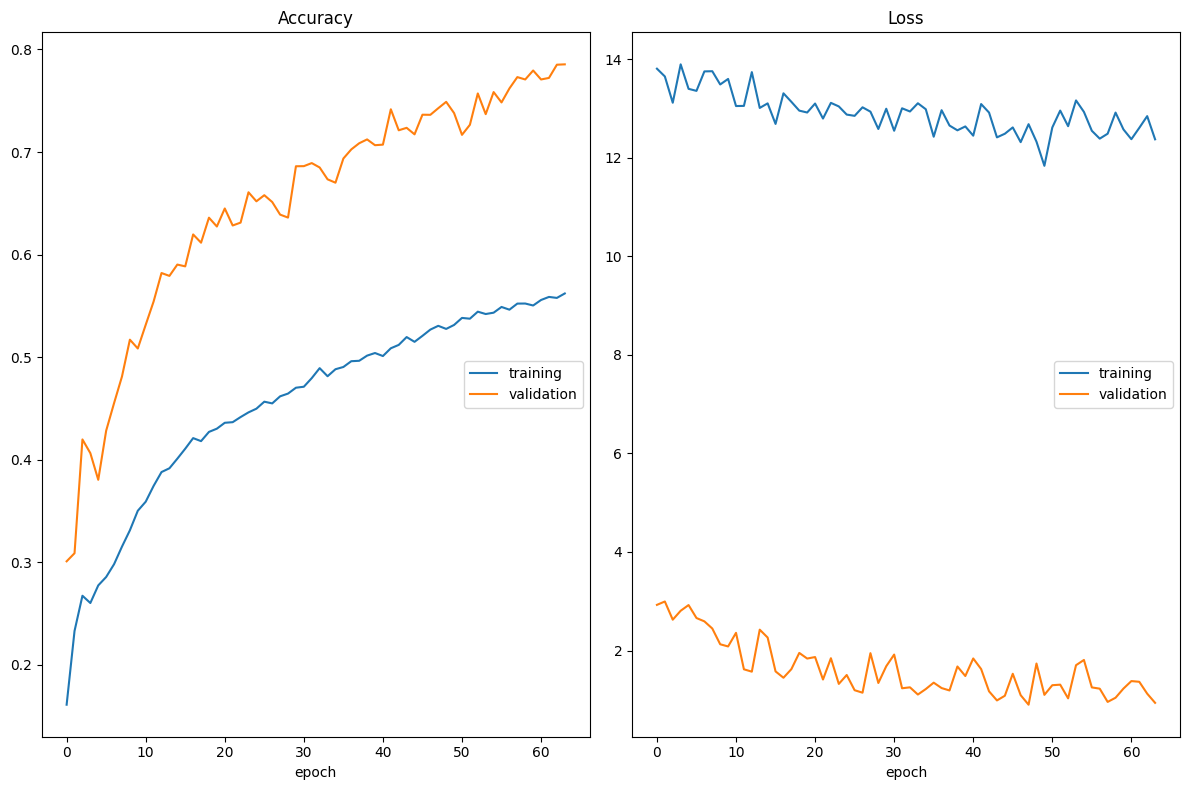

Accuracy
	training         	 (min:    0.161, max:    0.562, cur:    0.562)
	validation       	 (min:    0.301, max:    0.785, cur:    0.785)
Loss
	training         	 (min:   11.834, max:   13.893, cur:   12.372)
	validation       	 (min:    0.901, max:    2.995, cur:    0.939)


In [ ]:

EPOCH = 300
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-7)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.)
trainer_obj.setOptimizer(optimizer, lr_scheduler)
filename = "{}/logs/{}".format(LCL_PATH, "cifar_64x64_out100.pth")
trainer_obj.run(train_dl, test_dl, EPOCH, filename)

In [ ]:

EPOCH = 100
history_path = "{}/{}".format(LCL_PATH, "logs/deep_5x_conf_logs.csv")
run_conf_obj = RunConfigs(model, trainer_obj, epochs=EPOCH, train_dl=train_dl, val_dl=test_dl, 
                          history_path=history_path, reset_layers=["fc, decode"])

In [ ]:

# name:(optimizer, (lr_scheduler=..., opt_hyperparameters=..., lr=float))

multiple_runs_conf = dict(
    adam=dict(optimizer=torch.optim.Adam,
            opt_hyperparameters=None,
            lr=0.001,
            lr_scheduler=None,
            lr_scheduler_hyperparameters=None,
    ),
    sgd=dict(optimizer=torch.optim.SGD, 
            opt_hyperparameters=None,
            lr=0.001,
            lr_scheduler=None,
            lr_scheduler_hyperparameters=None,
    ),
    sgd_momentum_nesterov=dict(optimizer=torch.optim.SGD, 
            opt_hyperparameters=dict(momentum=0.9, nesterov=True),
            lr=0.001,
            lr_scheduler=None,
            lr_scheduler_hyperparameters=None,
    ),
    sgd_momentum_nesterov_weight_decay=dict(optimizer=torch.optim.SGD, 
            opt_hyperparameters=dict(momentum=0.9, nesterov=True, weight_decay=0.01),
            lr=0.001,
            lr_scheduler=None,
            lr_scheduler_hyperparameters=None,
    ),
    adamW=dict(optimizer=torch.optim.AdamW,
            opt_hyperparameters=dict(fused=True),
            lr=0.001,
            lr_scheduler=None,
            lr_scheduler_hyperparameters=None,
    ),
    # scheduler
    sgd_scheduler=dict(optimizer=torch.optim.SGD,
            opt_hyperparameters=None,
            lr=0.001,
            lr_scheduler=torch.optim.lr_scheduler.OneCycleLR,
            lr_scheduler_hyperparameters=dict(max_lr=0.1, steps_per_epoch=10, epochs=EPOCH), 
    ),
    sgd_momentum_nesterov_scheduler=dict(optimizer=torch.optim.SGD,
            opt_hyperparameters=dict(momentum=0.9, nesterov=True),
            lr=0.001,
            lr_scheduler=torch.optim.lr_scheduler.OneCycleLR,
            lr_scheduler_hyperparameters=dict(max_lr=0.1, steps_per_epoch=10, epochs=EPOCH), 
    ),
    adam_scheduler=dict(optimizer=torch.optim.Adam, 
            opt_hyperparameters=None,
            lr=0.001,
            lr_scheduler=torch.optim.lr_scheduler.OneCycleLR,
            lr_scheduler_hyperparameters=dict(max_lr=0.1, steps_per_epoch=10, epochs=EPOCH), 
    ),
)
multiple_runs_conf

In [ ]:

run_conf_obj(**multiple_runs_conf)

The comments are self-explainatory. If you do not know what a transformation does, the official documentation is your friend.
Reading documentation helps your brain.

The full training script is available in [complex_yet_simple_training_pipeline.py](./complex_yet_simple_training_pipeline.py).

## Excercises

1. Create your own efficient training pipeline for CIFAR-10.
2. Adapt your pipeline (and this pipeline) to use some batched transformations. Measure the speedup!
3. Adapt your pipeline (and this pipeline) to include Automatic Mixed Precision. Read the documentation first!
4. Adjust your pipeline (or this pipeline) to achieve 96% on CIFAR-10 (hard). You may change the model, but pretrained weights are forbidden.

---

| All     | [advanced_pytorch/](https://github.com/Tensor-Reloaded/AI-Learning-Hub/blob/main/resources/advanced_pytorch) |
|---------|-- |
| Current | [A complex yet simple efficient training pipeline for CIFAR-10](https://github.com/Tensor-Reloaded/AI-Learning-Hub/blob/main/resources/advanced_pytorch/ComplexYetSimpleTrainingPipeline.ipynb) |